In [1]:
import datatable as dt
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

import lightgbm as lgb
from collections import defaultdict
from sklearn.model_selection import GroupKFold

#import riiideducation

In [2]:
data_path = '../input/riiid-test-answer-prediction/train.csv'
questions_path = '../input/riiid-test-answer-prediction/questions.csv'
data_types_dict = {
    'user_id': 'int32',
    'content_id': 'int16',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [3]:
train_df = dt.fread(data_path, columns=set(data_types_dict.keys())).to_pandas()
questions_df = pd.read_csv(
    questions_path,
    usecols=[0, 3],
    dtype={'question_id': 'int16', 'part': 'int8'}
)

In [5]:
train_df.user_id.nunique()

393656

In [6]:
# preprocess
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)

train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

train_df = train_df.groupby('user_id').tail(12).reset_index(drop=True)  

train_df = pd.merge(train_df, 
                    questions_df,
                    left_on='content_id', 
                    right_on='question_id', 
                    how='left')
train_df.drop(columns=['question_id'], inplace=True)

train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

train_df

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part,content_count
0,115,0.745495,1,NaN,False,NaN,5,36514
1,115,0.734901,1,37000.0,False,1.000000,5,23991
2,115,0.966869,1,55000.0,False,1.000000,1,19619
3,115,0.954815,1,19000.0,False,1.000000,1,21733
4,115,0.953218,1,11000.0,False,1.000000,1,19409
...,...,...,...,...,...,...,...,...
99271295,2147482888,0.741063,1,18000.0,True,0.500000,5,4364
99271296,2147482888,0.527789,1,14000.0,True,0.521739,5,10220
99271297,2147482888,0.616202,1,14000.0,True,0.541667,5,31415
99271298,2147482888,0.661683,0,22000.0,True,0.560000,5,5752


In [8]:
gkf = GroupKFold(5)
for n, fold_idx in enumerate(gkf.split(train_df, groups=train_df.user_id)):
    print(n, fold_idx)

0 (array([       0,        1,        2, ..., 99271297, 99271298, 99271299]), array([      46,       47,       48, ..., 99271270, 99271271, 99271272]))
1 (array([       0,        1,        2, ..., 99271297, 99271298, 99271299]), array([     611,      612,      613, ..., 99269694, 99269695, 99269696]))
2 (array([      46,       47,       48, ..., 99271297, 99271298, 99271299]), array([       0,        1,        2, ..., 99270945, 99270946, 99270947]))
3 (array([       0,        1,        2, ..., 99271270, 99271271, 99271272]), array([      76,       77,       78, ..., 99271297, 99271298, 99271299]))
4 (array([       0,        1,        2, ..., 99271297, 99271298, 99271299]), array([    8630,     8631,     8632, ..., 99270193, 99270194, 99270195]))


In [9]:
features = [
    'content_id', 
    'prior_question_elapsed_time',
    'prior_question_had_explanation', 
    'user_correctness', 
    'part',
    'content_count'
]

trn_idx, val_idx = fold_idx
trn_data = lgb.Dataset(train_df.loc[trn_idx][features],
                      label=train_df.loc[trn_idx][target])
val_data = lgb.Dataset(train_df.loc[val_idx][features],
                      label=train_df.loc[val_idx][target])

In [10]:
params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}

model = lgb.train(params,
                  trn_data,
                  num_boost_round=10000,
                  valid_sets=[trn_data, val_data],
                  early_stopping_rounds=50,
                  verbose_eval=50)

[LightGBM] [Info] Number of positive: 52208037, number of negative: 27209003
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3143
[LightGBM] [Info] Number of data points in the train set: 79417040, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657391 -> initscore=0.651689
[LightGBM] [Info] Start training from score 0.651689
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10]	training's auc: 0.747306	valid_1's auc: 0.747428


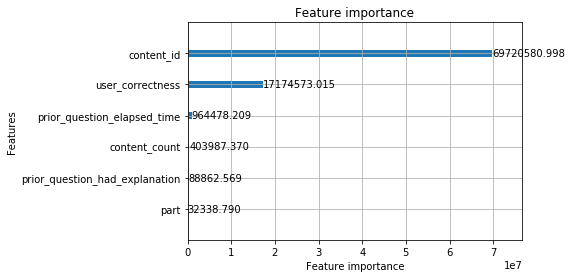

In [11]:
lgb.plot_importance(model, importance_type='gain')

In [37]:
save_path = f'lgb_fold{n}.txt'
model.save_model(save_path)

In [39]:
# model = lgb.Booster(model_file=save_path)
# model.predict(train_df.loc[val_idx][features])

In [18]:
from sklearn.svm import SVC

In [23]:
train_df.fillna(0, inplace=True)

In [19]:
model2 = SVC(C=50)

In [ ]:
model2.fit(train_df.loc[trn_idx][features], train_df.loc[trn_idx][target])

In [ ]:
model2.fit(train_df)

# inference

In [58]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [ ]:
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [ ]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        
        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
       
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])